# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt
from pathlib import Path
import os
import torch
from torchvision import transforms
import glob

import networks
from utils import download_model_if_doesnt_exist

In [2]:
dirpath = "C:/Users/trand/Berkeley_Inter/PANDA_dataset"
image_files = glob.glob(os.path.join(dirpath, '*.png'))  # Use the appropriate file extension
print(len(image_files))


3319


In [3]:
print(np.load("C:/Users/trand/monodepth2/assets/test_image_depth.npy"))

[[[[41.735916  41.748318  41.86955   ... 43.722008  43.70286
    43.56099  ]
   [41.4038    41.36015   41.5195    ... 43.71256   43.696537
    43.55082  ]
   [40.84564   40.84373   41.00446   ... 43.608585  43.556065
    43.43692  ]
   ...
   [ 5.48905    5.5466332  5.580327  ...  5.4939485  5.4757247
     5.4584837]
   [ 5.450697   5.507829   5.540608  ...  5.43806    5.4213805
     5.4040446]
   [ 5.4154     5.4732623  5.5121493 ...  5.3996487  5.381748
     5.3659477]]]]


## Setting up network and loading weights

In [2]:
model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

-> Downloading pretrained model to models\mono_640x192.zip
   Unzipping model...
   Model unzipped to models\mono_640x192


c:\Users\trand\anaconda3\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\trand\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Loading the test image and preprocessing

In [7]:
dirpath = "C:/Users/trand/Berkeley_Inter/demo2"
paths = sorted(Path(dirpath).iterdir(), key=os.path.getmtime)

# input_image = pil.open(image_path).convert('RGB')
# original_width, original_height = input_image.size

# feed_height = loaded_dict_enc['height']
# feed_width = loaded_dict_enc['width']
# input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

# input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

## Prediction using the PyTorch model

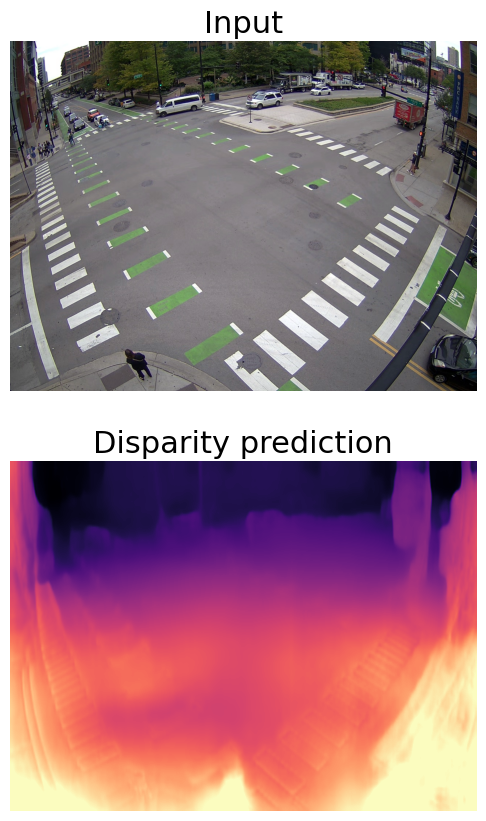

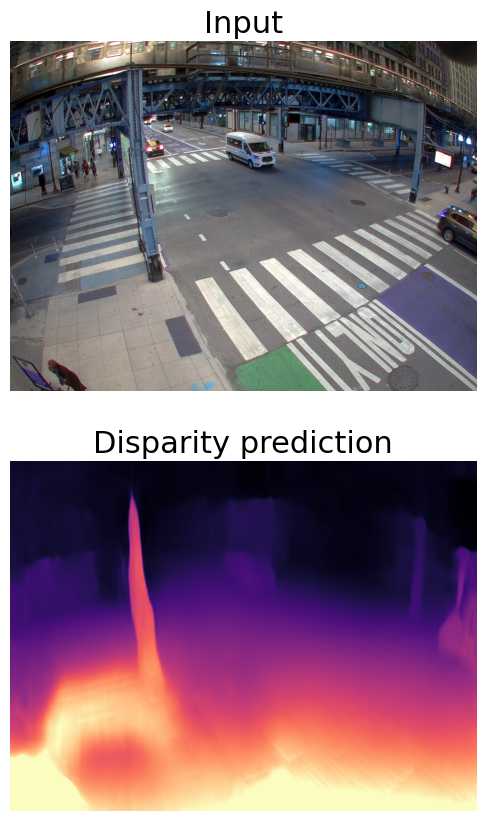

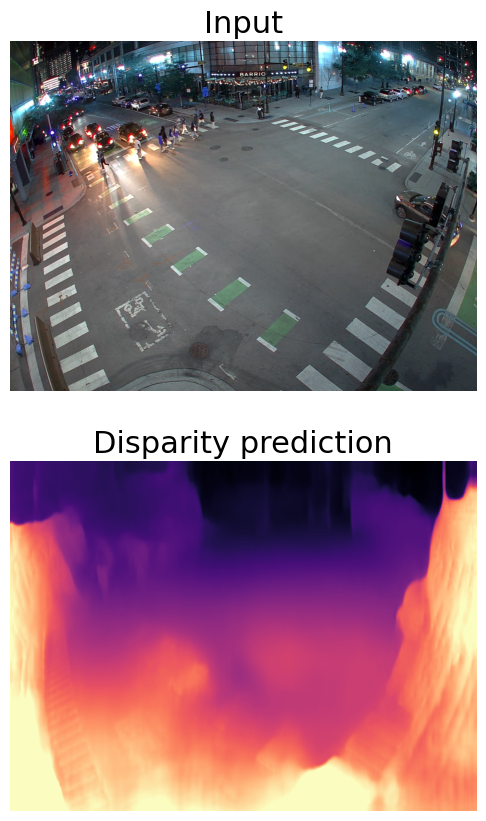

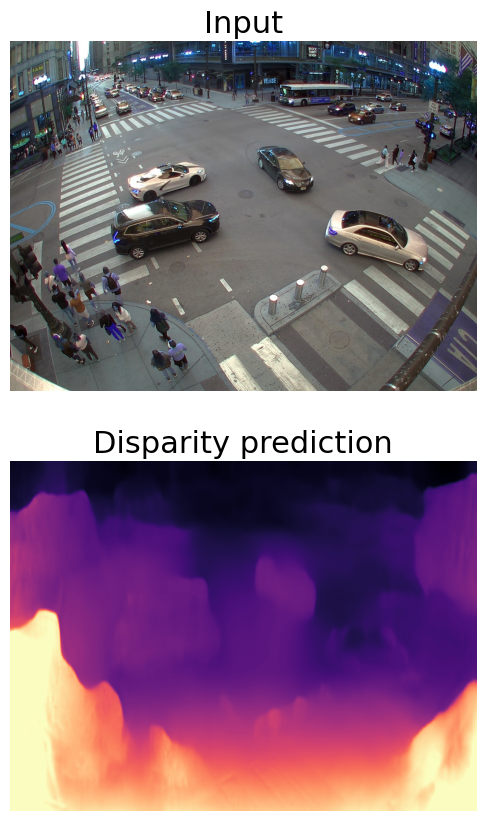

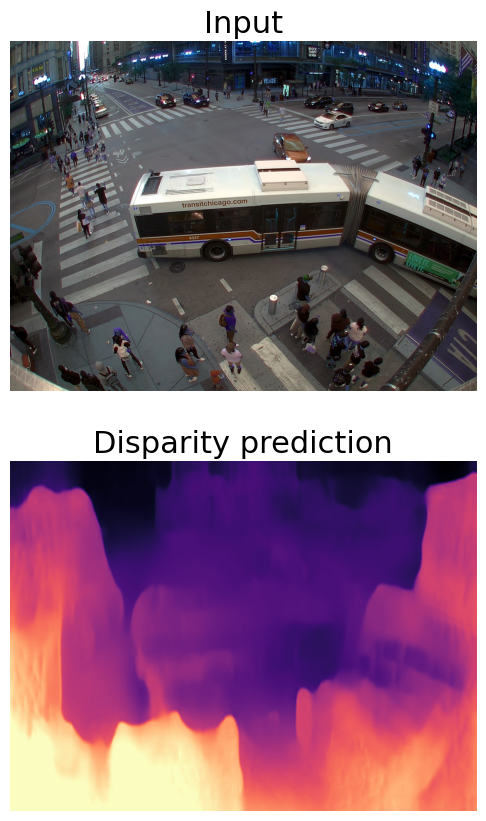

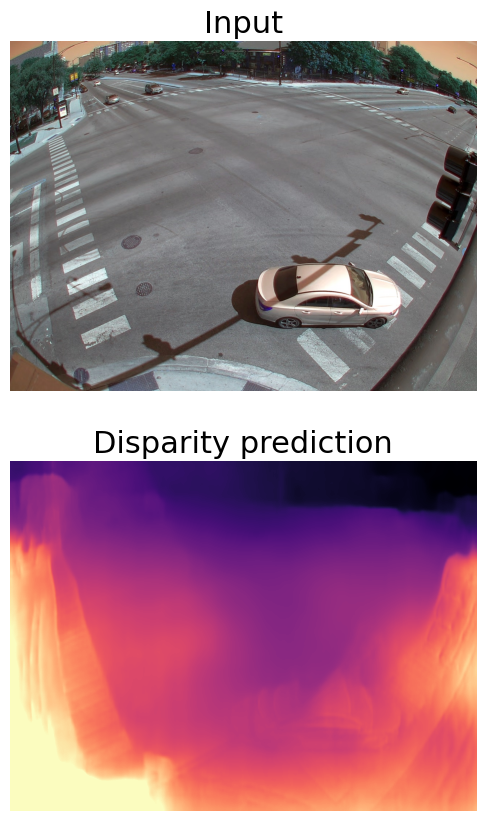

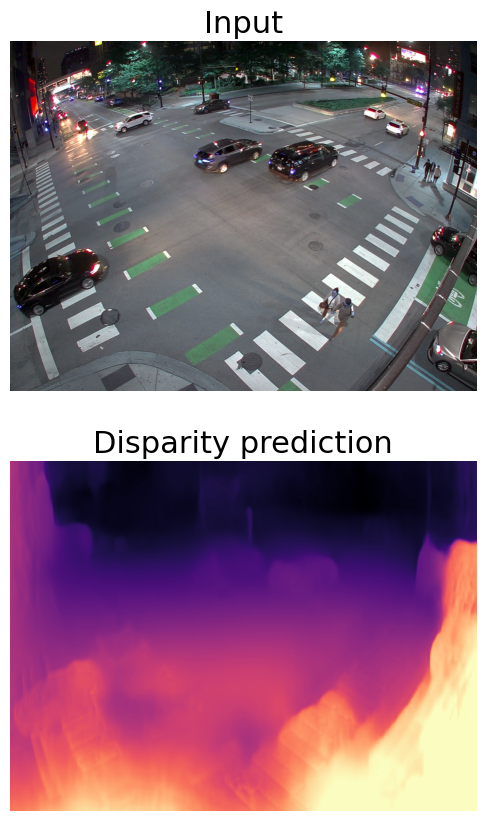

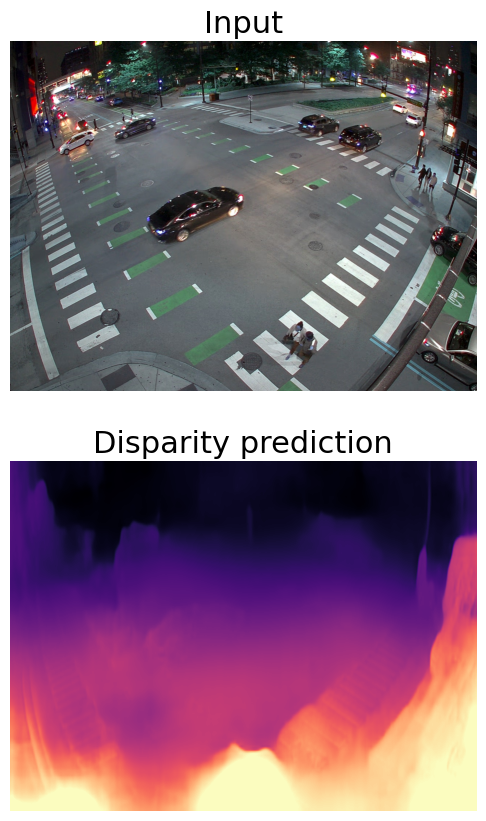

In [9]:
for image_path in paths:
    input_image = pil.open(image_path).convert('RGB')
    original_width, original_height = input_image.size

    feed_height = loaded_dict_enc['height']
    feed_width = loaded_dict_enc['width']
    input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

    input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)
    with torch.no_grad():
        features = encoder(input_image_pytorch)
        outputs = depth_decoder(features)

    disp = outputs[("disp", 0)]

    disp_resized = torch.nn.functional.interpolate(disp,
        (original_height, original_width), mode="bilinear", align_corners=False)

    # Saving colormapped depth image
    disp_resized_np = disp_resized.squeeze().cpu().numpy()
    vmax = np.percentile(disp_resized_np, 95)

    plt.figure(figsize=(10, 10))
    plt.subplot(211)
    plt.imshow(input_image)
    plt.title("Input", fontsize=22)
    plt.axis('off')

    plt.subplot(212)
    plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
    plt.title("Disparity prediction", fontsize=22)
    plt.axis('off')

## Plotting

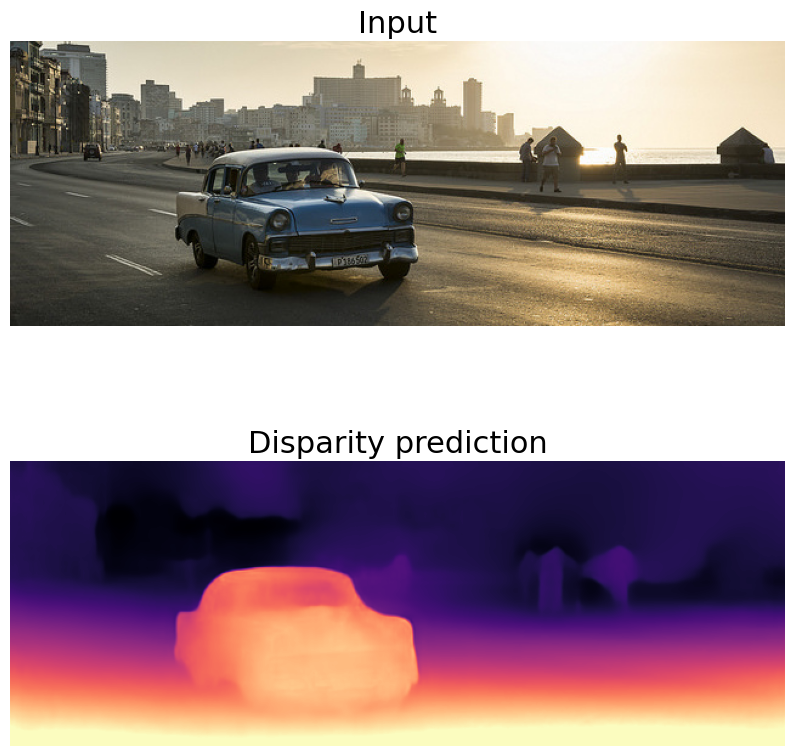

In [5]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off')